<a href="https://colab.research.google.com/github/FarnazG/dsc-capstone-project-v2-online-ds-ft-120919/blob/master/Transfer_learning3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Preprocessing Phase2:**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from keras import losses

import numpy as np #for numerical computations
import pandas as pd #for dataframe operations

from matplotlib import pyplot as plt #for viewing images and plots
%matplotlib inline 
#So that Matplotlib plots don't open in separate windows outside the notebook

import urllib #For fetching data from Web URLs

import cv2   #For image processing

from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of dataset

#All tensorflow utilities for creating, training and working with a CNN
from keras import losses
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, Input #, merge
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
#from tensorflow.keras.models import load_model, Model
from keras.models import load_model, Model
from keras.regularizers import l2
#from tensorflow.keras.utils import np_utils

Using TensorFlow backend.


# **After 'X' is downloaded:**


In [0]:
# some URL images that were not readable were deleted:
X3 = np.load('/content/drive/My Drive/Capstone Project/X_gray_df2598.npy') 
X2 = np.load('/content/drive/My Drive/Capstone Project/X_gray_df2000.npy') 
X1 = np.load('/content/drive/My Drive/Capstone Project/X_gray_df1000.npy') 
X = np.concatenate((X1, X2, X3))
print(X.shape)

#gray image size grayscale 1 color
img_size=(400,300)

#colored image size RGB 3 Colors
#img_size=(400,300,3)

(2598, 120000)


To see how well the image processing works , we will fetch 5 samples from 'X' at random and plot them:

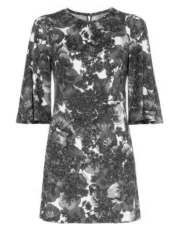

In [0]:
#Select 5 processed images at random from 'X' and plot 
for i in range(0, 1):
  plt.figure()
  plt.imshow(X[i].reshape(img_size), cmap='gray'), plt.axis('off')

**Splitting the data:**

We need to split the data into training, validation, and test sets.

**Creating the Target Array:**

We already have our 'X'. Now, we need our 'Y'.

We will ceate it from the 'Price' column of our dataframe.

if we use brand name column as 'y', It consists of the categorical labels. then We will map each label with a number using the LabelEncoder.

In [0]:
df= pd.read_csv('/content/drive/My Drive/Capstone Project/df.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,brand.id,brand.name,gender,hasSimilarProducts,id,images.cutOut,images.model,isCustomizable,merchandiseLabelField,merchantId,priceInfo.currencyCode,priceInfo.finalPrice,priceInfo.formattedFinalPrice,priceInfo.formattedInitialPrice,priceInfo.initialPrice,priceInfo.isOnSale,shortDescription,stockTotal
0,0,41,3440,Dolce & Gabbana,women,True,13951532,https://cdn-images.farfetch-contents.com/13/95...,https://cdn-images.farfetch-contents.com/13/95...,False,NewSeason,9359,SGD,1124,"$1,124","$1,124",1124,False,Geranium print mini dress,38
1,1,57,25354,Gucci,women,True,13579955,https://cdn-images.farfetch-contents.com/13/57...,https://cdn-images.farfetch-contents.com/13/57...,False,NoTag,9359,SGD,2200,"$2,200","$2,200",2200,False,Stirrups print blouse,13
2,2,122,547344,Saint Laurent,women,True,14031265,https://cdn-images.farfetch-contents.com/14/03...,https://cdn-images.farfetch-contents.com/14/03...,False,NewSeason,9359,SGD,2620,"$2,620","$2,620",2620,False,Zebra print peplum skirt,4
3,3,128,3440,Dolce & Gabbana,women,True,13951202,https://cdn-images.farfetch-contents.com/13/95...,https://cdn-images.farfetch-contents.com/13/95...,False,NewSeason,9359,SGD,3200,"$3,200","$3,200",3200,False,Lily print flounce dress,18
4,4,96,3440,Dolce & Gabbana,women,True,13922305,https://cdn-images.farfetch-contents.com/13/92...,https://cdn-images.farfetch-contents.com/13/92...,False,NoTag,9541,SGD,4273,"$4,273","$4,273",4273,False,graffiti art print jacket,1


In [0]:
n_classes = df['brand.name'].nunique()
print('Total number of unique categories:', n_classes)

Total number of unique categories: 5


In [0]:
encoder = LabelEncoder()
Targets = encoder.fit_transform(df['brand.name'])
Targets
Targets.shape

(2598,)

In [0]:
Y = to_categorical(Targets, num_classes = n_classes)
#Y[0:3]
Y.shape

(2598, 5)

**Separation of a validation set, and a test set:**

In [0]:
# we consider 80% of our data as training and 20% as testing:
X_test = X[2000:,]
Y_test = Y[2000:,]

#Seperation of a validation set 15% from the remaing training set (required for validation while training)

X_train, X_val, Y_train, Y_val = train_test_split(X[:2000,], Y[:2000,], test_size=0.3, shuffle=True)

**Reshaping the input data**

we already reshaped out images earlier into 360000x1 row arrays, since it was easier to store them that way. But CNN requires input data in form of nice multi-dimensional grids. For our colored image data, the third dimesion will be 3 and for gray-scale is 1.

In [0]:
#Reshape the input matrices such that each sample is three-dimensional
#normalizing images between 0 and 1 while splitting the data: X = X/255

img_rows, img_cols = 400, 300
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_train = X_train/255
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_test = X_test/255
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_val = X_val/255

X_val.shape

(600, 400, 300, 1)

#  Transfer learnng:

we are going to use transfer learning, the original model we will use is an already trained model on fashion clothing images from kaggle website: 
model_org.hdf5, we will use part of the model and its weights as our starting point to develope our network:

In [0]:
#Define a Convolutional Neural Network Model for the original model
def loadOriginalModel(input_tensor=None, n_classes=1000):

  img_input = input_tensor

  #model = Sequential()
  x=Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', name="Conv2d_1")(img_input)
  x=BatchNormalization(name="BN_1")(x)
  x=Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', name="Conv2d_2")(x)
  x=BatchNormalization(name="BN_2")(x)
  x=MaxPool2D(strides=(2,2))(x)
  x=Dropout(0.25, name="Drp_1")(x)
  
  x=Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', name="Conv2d_3")(x)
  x=BatchNormalization(name="BN_3")(x)
  x=Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', name="Conv2d_4")(x)
  x=BatchNormalization(name="BN_4")(x)
  x=MaxPool2D(strides=(2,2))(x)
  x=Dropout(0.25, name="Drp_2")(x)
  
  x=Flatten()(x)
  x=Dense(512, activation='relu', name="Dense_1")(x)
  x=Dropout(0.25)(x)
  
  x=Dense(1024, activation='relu', name="Dense_2")(x)
  x=Dropout(0.4)(x)

  x=Dense(n_classes, activation='softmax')(x)

  model = Model(img_input, x)
  
   
  # learning_rate = 0.001
  
  # model.compile(loss = categorical_crossentropy,
  #               optimizer = Adam(learning_rate),
  #               metrics=['accuracy'])
  
  # model.summary()
  return model

In [0]:
#The Original Model summary
original_input = Input(shape=(100, 100, 1), name='original_input')
original_model = loadOriginalModel(input_tensor=original_input, n_classes=17)
original_model.load_weights('/content/drive/My Drive/Capstone Project/model_org.hdf5')
original_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_input (InputLayer)  (None, 100, 100, 1)       0         
_________________________________________________________________
Conv2d_1 (Conv2D)            (None, 98, 98, 16)        160       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 98, 98, 16)        64        
_________________________________________________________________
Conv2d_2 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
Drp_1 (Dropout)              (None, 48, 48, 16)        0   

In [0]:
#Define a Convolutional Neural Network Model for custom model
def loadCustomModel(input_tensor=None, n_classes=1000):

  img_input = input_tensor

  #model = Sequential()
  x=Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', name="Conv2d_1")(img_input)
  x=BatchNormalization(name="BN_1")(x)
  x=Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', name="Conv2d_2")(x)
  x=BatchNormalization(name="BN_2")(x)
  x=MaxPool2D(strides=(2,2))(x)
  #x=Dropout(0.5, name="Drp_1")(x)
  
  x=Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', name="Conv2d_3")(x)
  x=BatchNormalization(name="BN_3")(x)
  x=Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', name="Conv2d_4")(x)
  x=BatchNormalization(name="BN_4")(x)
  x=MaxPool2D(strides=(2,2))(x)
  #x=Dropout(0.5, name="Drp_2")(x)
  
  # We add two conv layers to the custom model which helps reduce the number of parameters in the custom mode,
  # since the custom model's input shape is different than the original model's input shape
  x=Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', name="Conv2d_5")(x)
  x=BatchNormalization(name="BN_5")(x)
  x=MaxPool2D(strides=(2,2))(x)
  #x=Dropout(0.5, name="Drp_3")(x)

  x=Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', name="Conv2d_6")(x)
  x=BatchNormalization(name="BN_6")(x)
  x=MaxPool2D(strides=(2,2))(x)
  #x=Dropout(0.5, name="Drp_4")(x)

  x=Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', name="Conv2d_7")(x)
  x=BatchNormalization(name="BN_7")(x)
  x=MaxPool2D(strides=(2,2))(x)
  #x=Dropout(0.5, name="Drp_5")(x)

  x=Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', name="Conv2d_8")(x)
  x=BatchNormalization(name="BN_8")(x)
  x=MaxPool2D(strides=(2,2))(x)
  #x=Dropout(0.5, name="Drp_6")(x)

  x=Flatten()(x)
  x=Dense(512, activation='relu', name="Dense_1", kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1))(x)
  x=Dropout(0.25)(x)
  
  x=Dense(1024, activation='relu', name="Dense_2", kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1))(x)
  x=Dropout(0.25)(x)

  x=Dense(n_classes, activation='softmax')(x)

  model = Model(img_input, x)
  
   
  # learning_rate = 0.001
  
  # model.compile(loss = categorical_crossentropy,
  #               optimizer = Adam(learning_rate),
  #               metrics=['accuracy'])
  
  # model.summary()
  return model

In [0]:
# custome model developing on the original model
custom_input = Input(shape=(400, 300, 1), name='new_input')
custom_model = loadCustomModel(input_tensor=custom_input, n_classes=5)

layer_name_list = ['Conv2d_1', 'Conv2d_2', 'Conv2d_3', 'Conv2d_4', 'BN_1', 'BN_2', 'BN_3', 'BN_4']

for layer_name in layer_name_list:
  custom_model.get_layer(name=layer_name).set_weights(original_model.get_layer(name=layer_name).get_weights())
  custom_model.get_layer(name=layer_name).trainable = False

layer_name_list = ['Conv2d_5', 'Conv2d_6', 'Conv2d_7', 'Conv2d_7']

for layer_name in layer_name_list:
  custom_model.get_layer(name=layer_name).set_weights(original_model.get_layer(name='Conv2d_4').get_weights())
  custom_model.get_layer(name=layer_name).trainable = False

layer_name_list = ['BN_5', 'BN_6', 'BN_7', 'BN_7']

for layer_name in layer_name_list:
  custom_model.get_layer(name=layer_name).set_weights(original_model.get_layer(name='BN_4').get_weights())
  custom_model.get_layer(name=layer_name).trainable = False

learning_rate = 0.001

custom_model.compile(loss = categorical_crossentropy,
              optimizer = Adam(learning_rate),
              metrics=['accuracy'])

custom_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
new_input (InputLayer)       (None, 400, 300, 1)       0         
_________________________________________________________________
Conv2d_1 (Conv2D)            (None, 398, 298, 16)      160       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 398, 298, 16)      64        
_________________________________________________________________
Conv2d_2 (Conv2D)            (None, 396, 296, 16)      2320      
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 396, 296, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 198, 148, 16)      0         
_________________________________________________________________
Conv2d_3 (Conv2D)            (None, 196, 146, 32)      4640

In [0]:
#Save the model during training 

save_at = "/content/drive/My Drive/Capstone Project/custom_model_8.hdf5"
save_best = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

Train on 1400 samples, validate on 600 samples
Epoch 1/15
1400/1400 [==============================] - 96s 69ms/step - loss: 99.8783 - accuracy: 0.2857 - val_loss: 90.1462 - val_accuracy: 0.3517
Epoch 2/15
1400/1400 [==============================] - 87s 62ms/step - loss: 85.4955 - accuracy: 0.3971 - val_loss: 76.1603 - val_accuracy: 0.3183
Epoch 3/15
1400/1400 [==============================] - 84s 60ms/step - loss: 71.8256 - accuracy: 0.4236 - val_loss: 63.5079 - val_accuracy: 0.3450
Epoch 4/15
1400/1400 [==============================] - 84s 60ms/step - loss: 59.6589 - accuracy: 0.4407 - val_loss: 52.4797 - val_accuracy: 0.3383
Epoch 5/15
1400/1400 [==============================] - 84s 60ms/step - loss: 49.1113 - accuracy: 0.4814 - val_loss: 43.0421 - val_accuracy: 0.3600
Epoch 6/15
1400/1400 [==============================] - 84s 60ms/step - loss: 40.1405 - accuracy: 0.4921 - val_loss: 35.0993 - val_accuracy: 0.3317
Epoch 7/15
1400/1400 [==============================] - 84s 60ms/

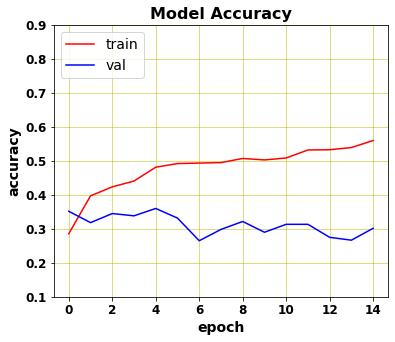

In [0]:
#Train the CNN

history = custom_model.fit( X_train, Y_train, 
                    epochs = 15, batch_size = 400, 
                    callbacks=[save_best], verbose=1, 
                    validation_data = (X_val, Y_val))

# Plot the training history (Training accuracy & Validation accuracy)

plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy', weight='bold', fontsize=16)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.1, 0.9)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

The model seems overfit and the accuracy, so we are going to work on the next approach which is one-vs-rest strategy and will compare the results in the next notebook.
